# Setup

## Libraries

In [385]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR

import statsmodels.api as sm
import itertools

warnings.filterwarnings('ignore')
# set to show all columns
pd.set_option('display.max_columns', 55)

print('hello')

hello


## Data Import

In [386]:
import pandas as pd
df2 = pd.read_csv('..\\raw_data\\full-year-ny-data.csv', parse_dates = ['date'])

# check import is good
# df2.info
# df2.dtypes

# ARIMA Model

An Autoregressive Integrated Moving Average (ARIMA) model is a statistical analysis which uses time series data.

The model is intended to better understand the trajectory of future forecasts related to a any particular time series.


## Stationary
For data to be stationary, the statistical properties of a system do not change over time, this means mean,
variance and co-various should be same over period of time.

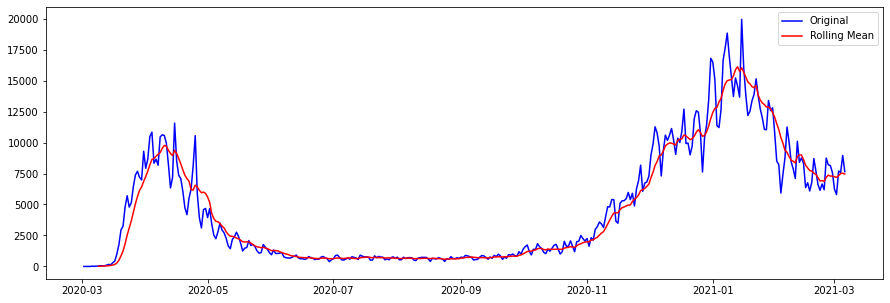

<Figure size 1080x360 with 0 Axes>

In [387]:
# Set up dataframe, mainly a date index and the number of cases per day
df_positive_cases = pd.DataFrame(df2, columns = ['date', 'positiveIncrease']) 
df_positive_cases.set_index('date', inplace = True)

# Extract the mean
rollmean = df_positive_cases.rolling(window=8).mean()

# Visual plot of the actual data set and the rolling mean
plt.plot(df_positive_cases, color = 'blue', label = 'Original')
plt.plot(rollmean, color = 'red', label = 'Rolling Mean')
plt.legend(loc = 'best')
plt.figure(figsize=(15, 5))
plt.show()

This is integrated of order 1 denoted by (d for difference). One of the parameter of ARIMA model.

In [388]:
# display head of data frame
print(df_positive_cases.head(15))

# difference has been set using periods (value of 11 gives difference of 11th past row; aka 11 days past)
df_positive_cases_diff = df_positive_cases.diff(periods=11)

# since the first 11 rows will have no difference to calculate, they will result in NA, hence we drop them
df_positive_cases_diff = df_positive_cases_diff.dropna()

# display results
df_positive_cases_diff.head()

            positiveIncrease
date                        
2020-03-02                 0
2020-03-03                 1
2020-03-04                 0
2020-03-05                 2
2020-03-06                22
2020-03-07                11
2020-03-08                24
2020-03-09                28
2020-03-10                63
2020-03-11                44
2020-03-12                56
2020-03-13               102
2020-03-14               164
2020-03-15               131
2020-03-16               294


,positiveIncrease
date,
2020-03-13,102.0
2020-03-14,163.0
2020-03-15,131.0
2020-03-16,292.0
2020-03-17,410.0


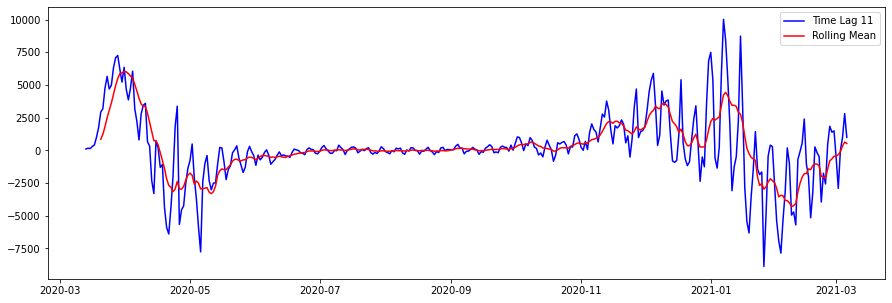

In [389]:
# configure plot parameters
plt.rc("figure", figsize=(15,5))

# here we are getting the mean per observation using the 8 previous observations *first 7 will be NaN
rollmean_2 = df_positive_cases_diff.rolling(window=8).mean()

# plot the rolling mean and the time lag of 11 days
plt.plot(df_positive_cases_diff, color = 'blue', label = 'Time Lag 11')
plt.plot(rollmean_2, color = 'red', label = 'Rolling Mean')
plt.legend(loc = 'best')
plt.show()

## AR Model

Auto Regressiove Model : An autoregressive (AR) model predicts future behavior based on past behavior.

287
359


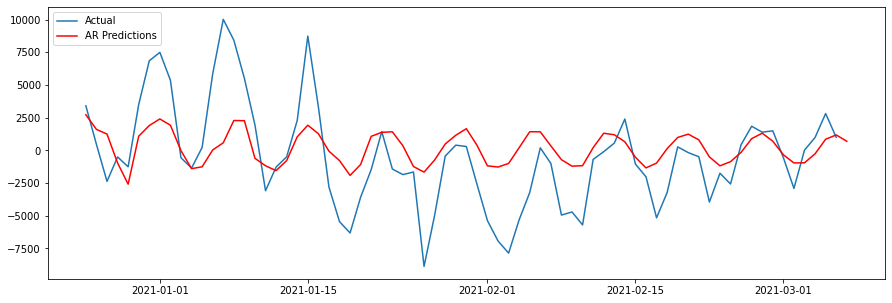

In [390]:
# divide data between training and test
# first get length of the first 80%
train_size = int(0.8 * len(df_positive_cases_diff))
# print(len(df_positive_cases_diff))

# use that length (80%) to set it as training data
train = df_positive_cases_diff[:train_size]

# set the rest for test data (20%)
test = df_positive_cases_diff[train_size:]

# train the model
model_AR = AR(train)
model_AR_fit = model_AR.fit()
start = len(train)
end = len(train)+len(test)
print(start)
print(end)

# predict and plot results
AR_predict = model_AR_fit.predict(start = start, end = end)
plt.plot(test)
plt.plot(AR_predict, color = 'red')
plt.legend(['Actual', 'AR Predictions'], loc='upper left')
plt.show()

# ARIMA Model

It combines both Autoregression (AR) and Moving Average (MA) models as well as a differencing pre-processing step of the
sequence to make the sequence stationary, called integration (I).

The notation for the model involves specifying the order for the AR(p), I(d), and MA(q) models as parameters to an ARIMA
function, e.g. ARIMA(p, d, q). An ARIMA model can also be used to develop AR, MA, and ARMA models.

In Time Series Analysis ARIMA the following assumptions have to be met:

* Data has to be stationary.
* Data should be univariate.
* Data should be in time series data format.

In [391]:
# df_positive = df2[['date', 'sevenDayAvg_newCases']]
# df_positive.set_index('date', inplace = True)

df_diff_2 = df_positive_cases.diff(axis = 0, periods=11)
df_diff_2 = df_diff_2.dropna()
print(df_diff_2.shape)

def ad_test(dataset):
    dftest = adfuller(dataset, autolag='AIC')
    print("1. ADF: ", dftest[0])
    print("p-value: ", dftest[1])
    print("No. of lags: ", dftest[2])
    print("No. of observation used for ADF regression and critical value calculation: ", dftest[3])
    print("Critical Value: " )
    for k,v in dftest[4].items():
        print("\t", k, " : ", v)

    
ad_test(df_diff_2['positiveIncrease'])    


(359, 1)
1. ADF:  -3.7329725004998746
p-value:  0.0036725585629574595
No. of lags:  11
No. of observation used for ADF regression and critical value calculation:  347
Critical Value: 
	 1%  :  -3.449336554273722
	 5%  :  -2.8699055166063085
	 10%  :  -2.571226758215748


p-value less than  0.05, this means dataset is stationary.

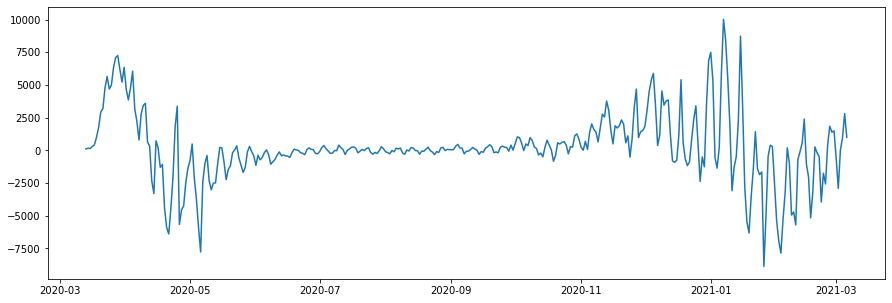

In [392]:
plt.plot(df_diff_2)


In [393]:
stepwise_fit = auto_arima(df_diff_2['positiveIncrease'], trace=True, suppress_warnings=True)
stepwise_fit.params()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=6294.898, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=6653.433, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=6325.376, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=6396.963, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6654.350, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=6299.419, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=6298.884, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=6301.115, Time=0.34 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=6289.902, Time=0.32 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=6295.227, Time=0.09 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=6155.857, Time=0.42 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=6283.0

array([ 6.20486458e-01,  5.35006990e-01, -5.76469089e-01, -4.79171505e-01,
        7.83479399e-01,  1.09217784e-01, -6.39731108e-01,  1.42988693e-01,
        6.18069278e-01,  1.20841109e+06])

In [394]:
print(df_diff_2.size)
train_arima = df_diff_2.iloc[:-30]
test_arima = df_diff_2.iloc[-30:]

# check to see the dimensions of the train and test data
print(train_arima.shape, test_arima.shape)

359
(329, 1) (30, 1)


In [395]:
model_ARIMA = ARIMA(train_arima['positiveIncrease'], order=(0,1,0))
model_ARIMA = model_ARIMA.fit()
model_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:     D.positiveIncrease   No. Observations:                  328
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2893.945
Method:                           css   S.D. of innovations           1642.649
Date:                Thu, 08 Apr 2021   AIC                           5791.891
Time:                        00:50:09   BIC                           5799.477
Sample:                    03-14-2020   HQIC                          5794.917
                         - 02-04-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.4878     90.700     -0.182      0.856    -194.257     161.281
==============================================================================
"""

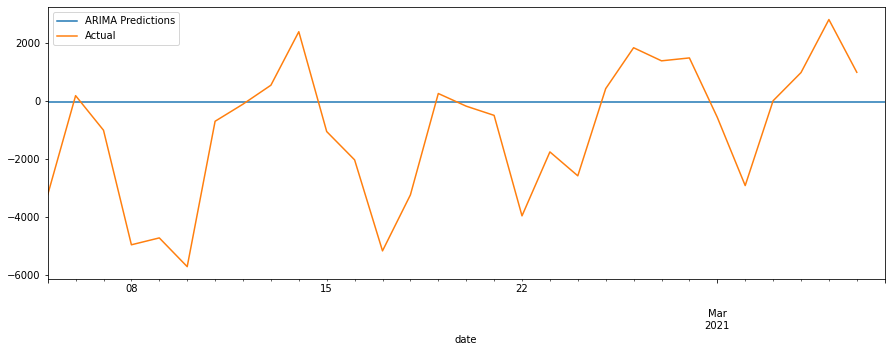

In [396]:
start_arima = len(train_arima)
end_arima = len(train_arima) + len(test_arima)
predict_arima = model_ARIMA.predict(start = start_arima, end = end_arima)
predict_arima.plot()
test_arima['positiveIncrease'].plot()
plt.legend(['ARIMA Predictions', 'Actual'], loc='best')


# SARIMA Model

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly
supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the
 seasonal component of the series, as well as an additional parameter for the period of the seasonality.

Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series.

Trend Elements
There are three trend elements that require configuration.

They are the same as the ARIMA model; specifically:

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

Seasonal Elements

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

* P: Seasonal autoregressive order.
* D: Seasonal difference order.
* Q: Seasonal moving average order.
* m: The number of time steps for a single seasonal period.

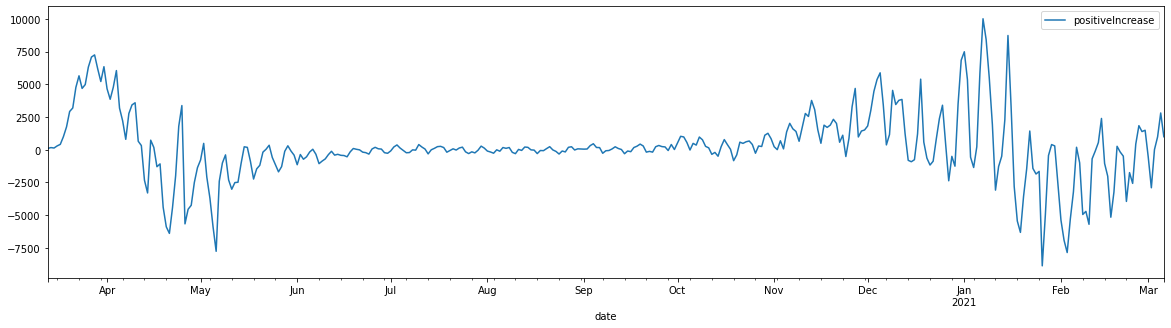

ARIMA(0, 0, 0)x(0, 0, 0, 11)12 - AIC:7523.293632384781
ARIMA(0, 0, 0)x(0, 0, 1, 11)12 - AIC:7111.141529415974
ARIMA(0, 0, 0)x(0, 1, 0, 11)12 - AIC:6636.817147796388
ARIMA(0, 0, 0)x(0, 1, 1, 11)12 - AIC:6435.16821316218
ARIMA(0, 0, 0)x(1, 0, 0, 11)12 - AIC:6648.66478692324
ARIMA(0, 0, 0)x(1, 0, 1, 11)12 - AIC:6640.522429222223
ARIMA(0, 0, 0)x(1, 1, 0, 11)12 - AIC:6451.122007641705
ARIMA(0, 0, 0)x(1, 1, 1, 11)12 - AIC:6430.871789578163
ARIMA(0, 0, 1)x(0, 0, 0, 11)12 - AIC:7239.983782238895
ARIMA(0, 0, 1)x(0, 0, 1, 11)12 - AIC:7007.966475598614
ARIMA(0, 0, 1)x(0, 1, 0, 11)12 - AIC:6374.1544509394525
ARIMA(0, 0, 1)x(0, 1, 1, 11)12 - AIC:6215.8706900027655
ARIMA(0, 0, 1)x(1, 0, 0, 11)12 - AIC:7018.659855821574
ARIMA(0, 0, 1)x(1, 0, 1, 11)12 - AIC:6347.607907524845
ARIMA(0, 0, 1)x(1, 1, 0, 11)12 - AIC:6190.8725475038245
ARIMA(0, 0, 1)x(1, 1, 1, 11)12 - AIC:6154.991786896428
ARIMA(0, 1, 0)x(0, 0, 0, 11)12 - AIC:6180.46562494731
ARIMA(0, 1, 0)x(0, 0, 1, 11)12 - AIC:5990.9764908954485
ARIMA(0, 

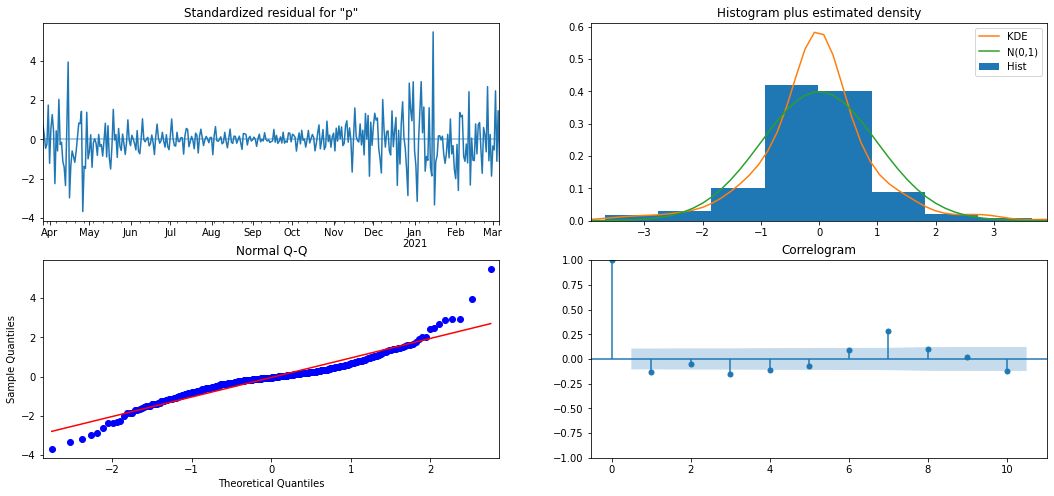

In [397]:
df_positive_cases_diff.plot(figsize=(20,5))
plt.show()

# set each to range of 0-2
p = d = q = range(0, 2)

# generate list of 8 combination 3 digit tuples of 0s and 1
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 11) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(df_positive_cases,order=param,seasonal_order=param_seasonal,
                                              enforce_stationarity=False,enforce_invertibility=False)
            results = model.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except:
            continue

# we set the order and seasonal order to the results of the AIC execution
model = sm.tsa.statespace.SARIMAX(df_positive_cases,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 11),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = model.fit()
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(18, 8))
plt.show()

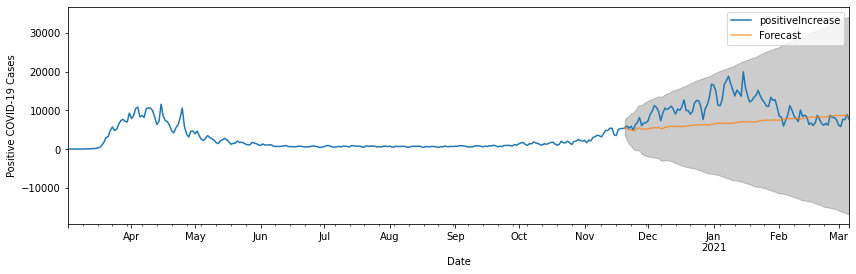

In [398]:
pred = results.get_prediction(start=pd.to_datetime('2020-11-20'), dynamic=True)
pred_ci = pred.conf_int()
ax = df_positive_cases['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Positive COVID-19 Cases')
plt.legend()
plt.show()